# OIL SPILL DETECTION SYSTEM 

# Module 1 – Milestone 1: Data Collection

## Introduction
In Module 1, we focus on **collecting and organizing the satellite image dataset** for oil spill detection.  
The goal is to acquire labeled images and masks, verify their quality, and structure the dataset for training, validation, and testing.  
This ensures the dataset is ready for further exploration and model development.

## Dataset Acquisition
Acquired satellite images from available sources, including corresponding **oil spill masks** for supervised learning.

## Labeled Annotations
Obtained the labeled masks for each image to indicate oil-contaminated regions.

## Dataset Organization
Organized the dataset into structured directories:
- `train/images` and `train/masks`
- `val/images` and `val/masks`
- `test/images` and `test/masks`
to maintain clear separation between training, validation, and testing data.


### Dataset Directory Overview

In this cell, we explore the dataset folder to understand its structure. 

- `os.walk()` is used to iterate through all subdirectories and list the number of files in each folder.  
- This helps verify that images and masks are correctly placed and gives an idea of dataset size before starting any processing.


In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
import cv2
dataset_dir = r"E:\Oil_Spill_Detection\dataset" 
for root, dirs, files in os.walk(dataset_dir):
    print(root, len(files))

E:\Oil_Spill_Detection\dataset 1
E:\Oil_Spill_Detection\dataset\test 0
E:\Oil_Spill_Detection\dataset\test\images 254
E:\Oil_Spill_Detection\dataset\test\masks 254
E:\Oil_Spill_Detection\dataset\train 0
E:\Oil_Spill_Detection\dataset\train\images 811
E:\Oil_Spill_Detection\dataset\train\masks 811
E:\Oil_Spill_Detection\dataset\val 0
E:\Oil_Spill_Detection\dataset\val\images 203
E:\Oil_Spill_Detection\dataset\val\masks 203


In [24]:


train_img_dir = os.path.join(dataset_dir, "train", "images")
train_mask_dir = os.path.join(dataset_dir, "train", "masks")

val_img_dir = os.path.join(dataset_dir, "val", "images")
val_mask_dir = os.path.join(dataset_dir, "val", "masks")

test_img_dir = os.path.join(dataset_dir, "test", "images")
test_mask_dir = os.path.join(dataset_dir, "test", "masks")


### Count of Images in Each Dataset Split

This cell counts the number of images in the **training, validation, and testing sets**.  

- `os.listdir()` lists all files in each folder.  
- `len()` gives the total number of images.  
- This check ensures that all dataset splits are properly organized and ready for further analysis.


In [25]:
train_img_paths = [os.path.join(train_img_dir, f) for f in os.listdir(train_img_dir)]
train_mask_paths = [os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir)]

val_img_paths = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir)]
val_mask_paths = [os.path.join(val_mask_dir, f) for f in os.listdir(val_mask_dir)]

test_img_paths = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir)]
test_mask_paths = [os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir)]

print("Train:", len(train_img_paths), len(train_mask_paths))
print("Val:", len(val_img_paths), len(val_mask_paths))
print("Test:", len(test_img_paths), len(test_mask_paths))


Train: 811 811
Val: 203 203
Test: 254 254


### Visualizing a Random Satellite Image and Its Mask

This cell randomly selects a training image and displays it alongside its corresponding mask.  

- `random.choice()` selects a random file from the image directory.  
- We match the image to its mask using the **filename without extension**.  
- `matplotlib` is used to display both the original satellite image and its oil spill mask side by side.  

This step helps verify that **images and masks are aligned correctly** before training the model.


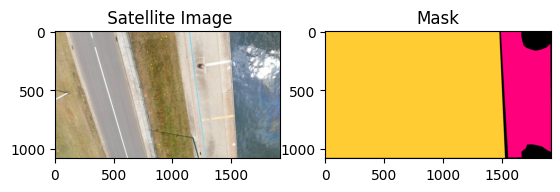

In [4]:
import random
import matplotlib.pyplot as plt
from PIL import Image

idx = random.randint(0, len(train_img_paths)-1)

img = Image.open(train_img_paths[idx])
mask = Image.open(train_mask_paths[idx])

plt.subplot(1,2,1)
plt.imshow(img)
plt.title(" Satellite Image")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Mask")

plt.show()


| Mask Color (RGB)       | Training Label             |
|------------------------|---------------------------|
| Magenta (255,0,124)    | 1 → Oil spill             |
| Black (0,0,0)          | 0 → Background            |
| Blue (51,221,255)      | 0 → Background / Water    |
| Yellow (255,204,51)    | 0 → Background / Other    |


### Checking Dataset Integrity

This cell checks if there are **any missing masks or images** in the training set.  

- The function compares the filenames (without extensions) in the **image** and **mask** directories.  
- It prints:  
  - Images that do not have a corresponding mask  
  - Masks that do not have a corresponding image  

This ensures that the dataset is **complete and ready for model training**.


In [5]:
def check_integrity(img_dir, mask_dir):
    img_names = {os.path.splitext(f)[0] for f in os.listdir(img_dir)}
    mask_names = {os.path.splitext(f)[0] for f in os.listdir(mask_dir)}
    
    missing_masks = img_names - mask_names
    missing_images = mask_names - img_names
    
    print("Images without masks:", missing_masks)
    print("Masks without images:", missing_images)

check_integrity(train_img_dir, train_mask_dir)


Images without masks: set()
Masks without images: set()


### Counting Masks Containing Oil Spill

This cell counts how many masks **contain oil spill** and how many do **not**:  

- `has_spill()` checks if there are any non-zero pixels in the mask, indicating the presence of oil.  
- Loops through all training masks and increments counters for **with spill** and **without spill**.  
- This gives an overview of the dataset’s composition and helps identify class balance.


In [6]:
def has_spill(mask_path):
    mask = np.array(Image.open(mask_path).convert("L"))
    return np.any(mask > 0)

with_spill = 0
without_spill = 0
for f in os.listdir(train_mask_dir):
    if has_spill(os.path.join(train_mask_dir, f)):
        with_spill += 1
    else:
        without_spill += 1

print("With Oil Spill:", with_spill)
print("Without Oil Spill:", without_spill)


With Oil Spill: 811
Without Oil Spill: 0


### File Format and Size Analysis

This cell analyzes the **size of images and masks** in the training dataset:

- `os.path.getsize()` is used to get the file size in bytes, then converted to KB.  
- We calculate the **average file size** for both images and masks.  
- This helps estimate the **dataset storage requirement** and check for unusually large or small files.


In [7]:
import os

img_sizes = [os.path.getsize(os.path.join(train_img_dir, f))/1024 for f in os.listdir(train_img_dir)]
mask_sizes = [os.path.getsize(os.path.join(train_mask_dir, f))/1024 for f in os.listdir(train_mask_dir)]

print("Average training image size (KB):", sum(img_sizes)/len(img_sizes))
print("Average mask size (KB):", sum(mask_sizes)/len(mask_sizes))


Average training image size (KB): 889.0158923204377
Average mask size (KB): 26.848064455533294


### Resolution / Dimension Check

This cell checks the **dimensions of all images** in the training set:

- `Image.open().size` returns the width and height of each image.  
- `set(dimensions)` shows the unique resolutions present in the dataset.  
- Understanding image size variability is important for **designing the input layer** of the deep learning model.


In [8]:
dimensions = [Image.open(os.path.join(train_img_dir, f)).size for f in os.listdir(train_img_dir)]
print("Unique dimensions in training set:", set(dimensions))


Unique dimensions in training set: {(1920, 1080), (768, 432), (3840, 2160), (5184, 2920), (4056, 3040), (5184, 3888)}


### Spill Area Analysis

This cell estimates the **size of oil spill regions** in each mask:

- Converts each mask to a NumPy array and counts pixels with value > 0.  
- `spill_areas` contains the number of pixels representing oil spills per mask.  
- Calculates **average, maximum, and minimum spill area** to understand how large the oil-contaminated regions are in the dataset.  
- This helps in understanding **dataset variability** and planning model evaluation metrics.


In [9]:
spill_areas = []
for f in os.listdir(train_mask_dir):
    mask = np.array(Image.open(os.path.join(train_mask_dir, f)).convert("L"))
    spill_areas.append(np.sum(mask > 0))

print("Average number of pixels with oil spill:", sum(spill_areas)/len(spill_areas))
print("Max spill area:", max(spill_areas))
print("Min spill area:", min(spill_areas))


Average number of pixels with oil spill: 2256369.404438964
Max spill area: 19513246
Min spill area: 311382


# 🛰️ Module 2: Data Preprocessing and Data Exploration

In this module, we prepare the satellite images and masks for model training.  
The main steps are:  

1. **Visualization** – Display sample satellite images with their masks to understand the dataset.  
2. **Resizing** – Standardize all images and masks to a fixed size (e.g., 256×256).  
3. **Normalization** – Scale pixel values to a common range for stable training.  
4. **SAR-specific filtering** – Apply speckle noise reduction to improve image quality.  
5. **Data Augmentation** – Increase dataset diversity with flipping, rotation, scaling, and brightness/contrast changes.  
6. **Statistical Analysis** – Study spill vs non-spill regions to understand data balance.  

This ensures the dataset is clean, uniform, and ready for deep learning.  


# 📌 Visualizing Satellite Images and Masks

- We randomly select one satellite image and its corresponding mask from the dataset.  
- The **satellite image** shows the original SAR (Synthetic Aperture Radar) data.  
- The **mask** highlights the regions of interest (e.g., oil spill, water, background).  
- Both are displayed side by side to understand how the dataset looks.  
- Finally, the file paths of the selected image and mask are printed.


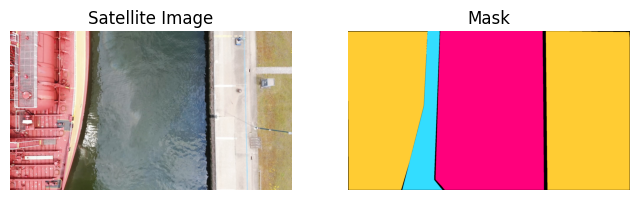

Random image path: E:\Oil_Spill_Detection\dataset\train\images\Oil (879).jpg
Random mask path: E:\Oil_Spill_Detection\dataset\train\masks\Oil (879).png


In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Define dataset directories
dataset_dir = r"E:\Oil_Spill_Detection\dataset"
train_img_dir = os.path.join(dataset_dir, "train", "images")
train_mask_dir = os.path.join(dataset_dir, "train", "masks")

# List all images and masks
img_files = os.listdir(train_img_dir)
mask_files = os.listdir(train_mask_dir)

# Pick a random index
idx = random.randint(0, len(img_files)-1)

# Get full paths
img_path = os.path.join(train_img_dir, img_files[idx])
mask_path = os.path.join(train_mask_dir, mask_files[idx])

# Open image and mask
img = Image.open(img_path)
mask = Image.open(mask_path)

# Show them side by side
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Satellite Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")

plt.show()

print("Random image path:", img_path)
print("Random mask path:", mask_path)


### Key Steps:
1. **Load Image & Mask**
   - Read the input image and its corresponding mask from the dataset.
   - Images are normalized from `[0–255]` to `[0–1]`.
   - Masks are binarized so that oil spill regions = `1`, background = `0`.

2. **Resize**
   - Both images and masks are resized to a fixed size of **256 × 256** pixels.  
   - This ensures consistency for feeding into the deep learning model.

3. **Median Filtering**
   - A **median filter** is applied to the images.
   - This helps to reduce noise while preserving important edges, which is useful in satellite/ocean images.

4. **Maintain Original Copy**
   - Both original and preprocessed versions are kept.
   - This allows us to visualize how preprocessing changes the data.

5. **Visualization**
   - Random samples from the dataset are plotted in a 2×2 grid:
     - Original Image  
     - Original Mask  
     - Resized Image (after preprocessing)  
     - Resized Mask  
   - This helps verify if the preprocessing pipeline is working correctly.

### Outcome:
- After running this step, we can **visually inspect** the dataset.
- Ensures that images and masks are aligned, correctly binarized, and prepared for training.

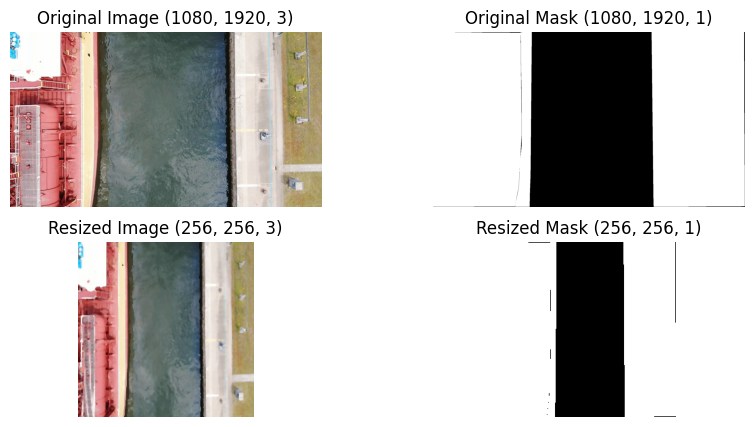

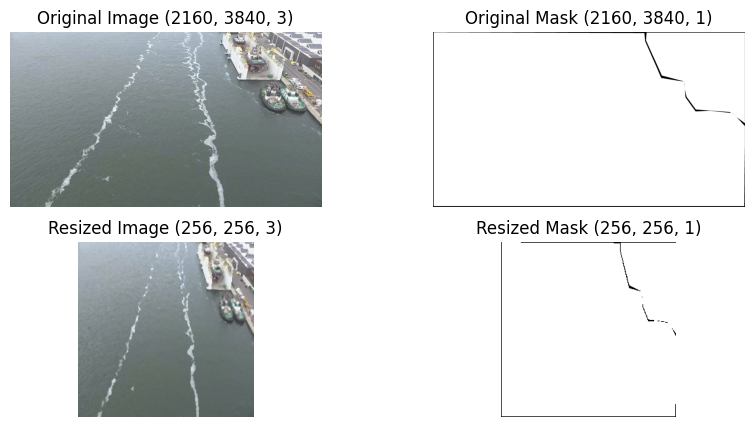

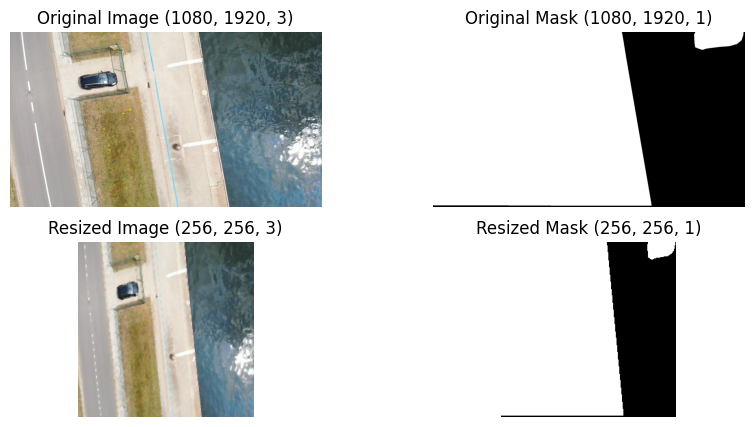

In [15]:


# --------------------
# SETTINGS
# --------------------
IMG_SIZE = (256, 256)

#dataset paths 
train_img_dir = r"E:\Oil_Spill_Detection\dataset\train\images"
train_mask_dir = r"E:\Oil_Spill_Detection\dataset\train\masks"

# --------------------
# FUNCTIONS
# --------------------
def apply_median_filter(img):
    img = img.numpy()
    img = cv2.medianBlur((img*255).astype(np.uint8), 3)  # filter
    img = img.astype(np.float32) / 255.0  # normalize again
    return img

def parse_image_mask(img_path, mask_path):
    # ---- Load Original Image ----
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # normalize 0-255 -> 0-1

    # ---- Load Original Mask ----
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask > 0.5, 1.0, 0.0)  # binarize

    # ---- Save Original Copy (for visualization) ----
    orig_img, orig_mask = img, mask

    # ---- Resize ----
    img = tf.image.resize(img, IMG_SIZE)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # ---- Apply Median Filter ----
    img = tf.py_function(apply_median_filter, [img], tf.float32)

    # ---- Set Shape ----
    img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])

    return orig_img, orig_mask, img, mask


# --------------------
# VISUALIZE RANDOM SAMPLES
# --------------------
def show_random_samples(n=3):
    img_files = os.listdir(train_img_dir)
    mask_files = os.listdir(train_mask_dir)

    for _ in range(n):
        idx = random.randint(0, len(img_files)-1)
        img_path = os.path.join(train_img_dir, img_files[idx])
        mask_path = os.path.join(train_mask_dir, mask_files[idx])

        orig_img, orig_mask, resized_img, resized_mask = parse_image_mask(img_path, mask_path)

        # Plot
        plt.figure(figsize=(10,5))

        plt.subplot(2,2,1)
        plt.imshow(orig_img.numpy())
        plt.title(f"Original Image {orig_img.shape}")
        plt.axis("off")

        plt.subplot(2,2,2)
        plt.imshow(orig_mask.numpy().squeeze(), cmap="gray")
        plt.title(f"Original Mask {orig_mask.shape}")
        plt.axis("off")

        plt.subplot(2,2,3)
        plt.imshow(resized_img.numpy())
        plt.title(f"Resized Image {resized_img.shape}")
        plt.axis("off")

        plt.subplot(2,2,4)
        plt.imshow(resized_mask.numpy().squeeze(), cmap="gray")
        plt.title(f"Resized Mask {resized_mask.shape}")
        plt.axis("off")

        plt.show()


# --------------------
# RUN
# --------------------
show_random_samples(n=3)  # show 3 random samples


### Key Steps:

1. **Parsing & Resizing**
   - Images and masks are loaded, resized to **256 × 256**, and normalized.

2. **Augmentation Techniques**
   - **Flipping**  
     - Random horizontal and vertical flips are applied.
   - **Rotation**  
     - Images and masks are rotated randomly in multiples of 90°.  
   - **Brightness & Contrast Adjustment**  
     - Random brightness and contrast changes simulate different lighting conditions.  
   - **Scaling (Zoom In/Out)**  
     - Images are slightly zoomed in or out, then padded/cropped back to the target size.

3. **Consistency Between Image & Mask**
   - All transformations applied to the image are **applied identically to the mask** so that labels remain aligned.

4. **Visualization**
   - For each random sample:
     - **Resized Image (without augmentation)**
     - **Augmented Image (after transformations)**  
   - This shows how augmentation alters the dataset.

---

### Outcome:
- Each run produces **unique augmented samples**.  
- The dataset effectively becomes much larger without needing additional real images.  
- Augmentation improves robustness and helps the model handle real-world variations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11551428..1.1821959].


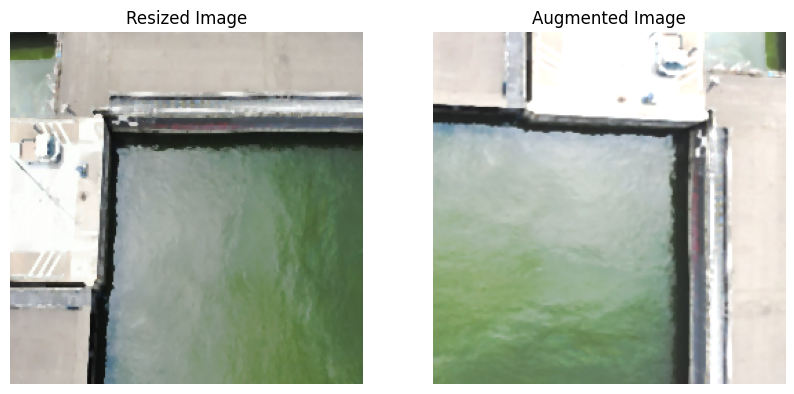

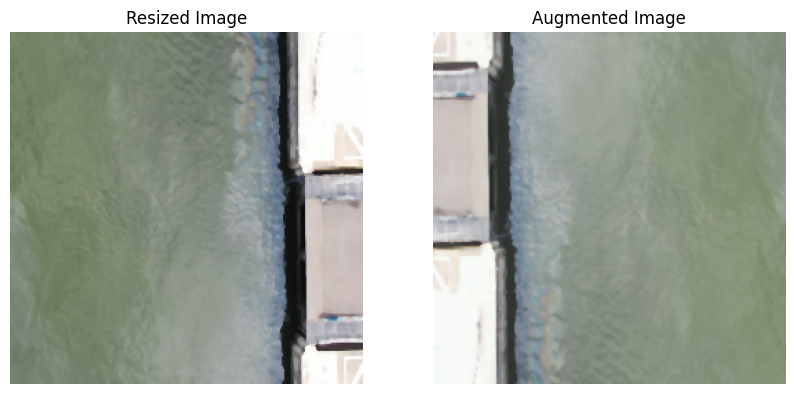

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.116952956..0.91632307].


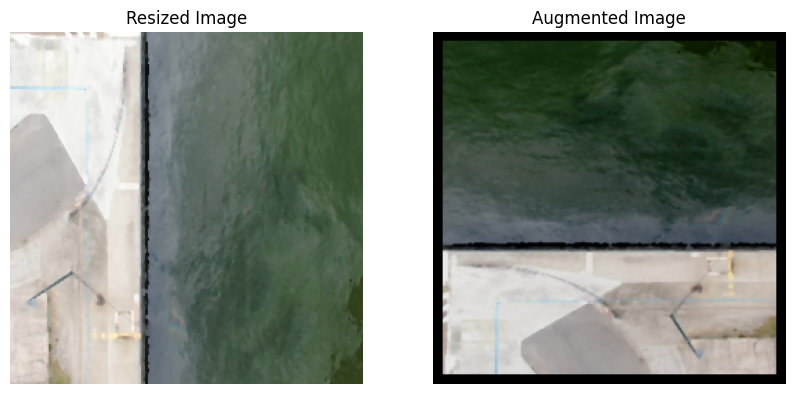

In [16]:
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

# --------------------
# SETTINGS
# --------------------
IMG_SIZE = (256, 256)
train_img_dir = r"E:\Oil_Spill_Detection\dataset\train\images"
train_mask_dir = r"E:\Oil_Spill_Detection\dataset\train\masks"

# --------------------
# FUNCTIONS
# --------------------
def apply_median_filter(img):
    img = img.numpy()
    img = cv2.medianBlur((img*255).astype(np.uint8), 3)
    img = img.astype(np.float32) / 255.0
    return img

def parse_and_resize(img_path, mask_path):
    # Load image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    # Resize
    img = tf.image.resize(img, IMG_SIZE)
    mask = tf.image.resize(mask, IMG_SIZE, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # Median filter
    img = tf.py_function(apply_median_filter, [img], tf.float32)
    img.set_shape([IMG_SIZE[0], IMG_SIZE[1], 3])
    mask.set_shape([IMG_SIZE[0], IMG_SIZE[1], 1])

    return img, mask

def augment_image_mask(img, mask):
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    img = tf.image.rot90(img, k)
    mask = tf.image.rot90(mask, k)

    img = tf.image.random_brightness(img, max_delta=0.15)
    img = tf.image.random_contrast(img, lower=0.85, upper=1.15)

    scale = tf.random.uniform([], 0.9, 1.1)
    new_size = (int(IMG_SIZE[0]*scale), int(IMG_SIZE[1]*scale))
    img = tf.image.resize(img, new_size)
    mask = tf.image.resize(mask, new_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE[0], IMG_SIZE[1])
    mask = tf.image.resize_with_crop_or_pad(mask, IMG_SIZE[0], IMG_SIZE[1])

    return img, mask

def show_augmentation_samples(n=3):
    img_files = os.listdir(train_img_dir)
    mask_files = os.listdir(train_mask_dir)

    for _ in range(n):
        idx = random.randint(0, len(img_files)-1)
        img_path = os.path.join(train_img_dir, img_files[idx])
        mask_path = os.path.join(train_mask_dir, mask_files[idx])

        # Parse & resize
        img, mask = parse_and_resize(img_path, mask_path)

        # Apply augmentation
        aug_img, aug_mask = augment_image_mask(img, mask)

        # Plot
        plt.figure(figsize=(10,5))

        plt.subplot(1,2,1)
        plt.imshow(img.numpy())
        plt.title("Resized Image")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(aug_img.numpy())
        plt.title("Augmented Image")
        plt.axis("off")

        plt.show()

# --------------------
# RUN
# --------------------
show_augmentation_samples(n=3)


1. **Dataset Creation**  
   - Create a TensorFlow dataset from image and mask file paths.  
   - Helps in efficient handling of large datasets.

2. **Shuffling (only for training)**  
   - Randomizes the order of samples to avoid model overfitting to sequence patterns.  

3. **Parsing and Resizing**  
   - Load each image-mask pair.  
   - Resize them to a fixed size of `256x256` for consistency.  

4. **Data Augmentation (only for training)**  
   - Apply transformations like flipping, rotation, brightness/contrast adjustments, and scaling.  
   - This improves the model’s robustness and prevents overfitting.  

5. **Batching**  
   - Group samples into batches of size `8` for efficient training.  

6. **Prefetching**  
   - Overlaps preprocessing and model execution for faster training.  

Finally, we create two datasets:  
- **Training Dataset** → shuffled, augmented, batched.  
- **Validation Dataset** → only parsed and resized, no augmentation. 

In [17]:
BATCH_SIZE = 8
BUFFER_SIZE = 512
AUTOTUNE = tf.data.AUTOTUNE

# --------------------
# DATASET PREPARATION
# --------------------
def prepare_dataset(img_paths, mask_paths, training=False):
    """
    Prepare a tf.data.Dataset with optional augmentation.
    img_paths, mask_paths: lists of file paths
    training: whether to apply augmentation
    """
    print(f"{'Training' if training else 'Validation'} dataset preparation started...")

    # Create dataset from image & mask paths
    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    print(f"Dataset created with {len(img_paths)} samples.")

    # Shuffle if training
    if training:
        ds = ds.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
        print("Dataset shuffled.")

    # Parse and resize images
    ds = ds.map(lambda x, y: parse_and_resize(x, y), num_parallel_calls=AUTOTUNE)
    print("Images and masks parsed and resized.")

    # Apply augmentation only for training
    if training:
        ds = ds.map(lambda img, mask: augment_image_mask(img, mask), num_parallel_calls=AUTOTUNE)
        print("Data augmentation applied.")

    # Batch + prefetch
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    print(f"Dataset batched with batch size {BATCH_SIZE} and prefetch applied.")
    print(f"{'Training' if training else 'Validation'} dataset is ready!\n")

    return ds

# --------------------
# USAGE
# --------------------
train_dataset = prepare_dataset(train_img_paths, train_mask_paths, training=True)
val_dataset   = prepare_dataset(val_img_paths, val_mask_paths, training=False)

# Optional: iterate to check batch shapes
for imgs, masks in train_dataset.take(1):
    print("Image batch shape:", imgs.shape)
    print("Mask batch shape:", masks.shape)


Training dataset preparation started...
Dataset created with 811 samples.
Dataset shuffled.
Images and masks parsed and resized.
Data augmentation applied.
Dataset batched with batch size 8 and prefetch applied.
Training dataset is ready!

Validation dataset preparation started...
Dataset created with 203 samples.
Images and masks parsed and resized.
Dataset batched with batch size 8 and prefetch applied.
Validation dataset is ready!

Image batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256, 1)


In this step, we visualize a **sample satellite image** along with its **corresponding segmentation mask** after preprocessing.  

- The **left plot** shows the satellite image after resizing, normalization, and filtering.  
- The **right plot** shows the corresponding binary segmentation mask (spill vs. non-spill regions).  
- This helps us verify that preprocessing was applied correctly and that the image-mask alignment is preserved.  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07746887..0.9372251].


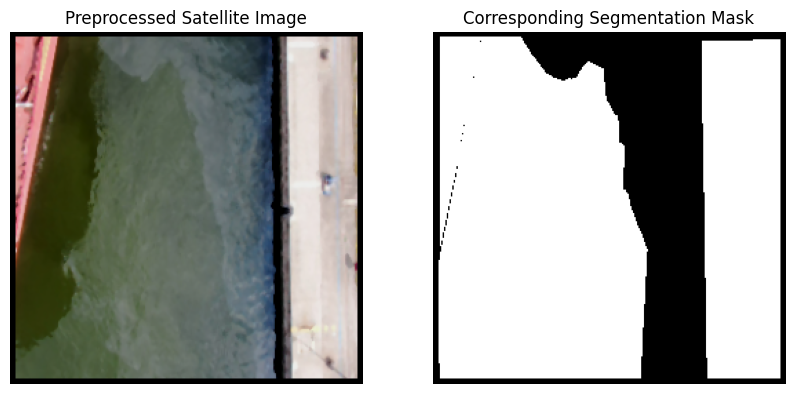

In [20]:
import matplotlib.pyplot as plt

for imgs, masks in train_dataset.take(1):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.imshow(imgs[0])
    plt.title("Preprocessed Satellite Image")  # Changed title
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(masks[0].numpy().squeeze(), cmap="gray")
    plt.title("Corresponding Segmentation Mask")  # Changed title
    plt.axis("off")
    
    plt.show()


# Statistical Analysis of Spill and Non-Spill Regions

In this step, we perform a **statistical study of the dataset** by analyzing the segmentation masks.  

### What we are doing:
- **Counting images**  
  - Total number of images in the dataset  
  - Number of images containing oil spills  
  - Number of images without oil spills  

- **Counting pixels**  
  - Total spill pixels (mask value = 1)  
  - Total non-spill pixels (mask value = 0)  
  - Fraction of spill vs. non-spill pixels  

- **Statistical properties of pixels**  
  - Mean and standard deviation of spill pixels  
  - Mean and standard deviation of non-spill pixels  

### Why this is useful:
- Helps understand **class imbalance** (spill vs. non-spill).  
- Ensures masks are correctly binarized (0 for non-spill, 1 for spill).  
- Provides an overview of dataset quality and distribution.  


In [21]:

# Counters
total_spill_pixels = 0
total_nonspill_pixels = 0
spill_pixel_values = []
nonspill_pixel_values = []
total_images = 0
spill_images_count = 0
nonspill_images_count = 0

for imgs, masks in train_dataset:  # Loop over dataset batches
    total_images += imgs.shape[0]

    for mask in masks:
        mask_np = mask.numpy().squeeze()  # Shape: (256,256)
        spill_pixels = mask_np.sum()
        nonspill_pixels = mask_np.size - spill_pixels

        total_spill_pixels += spill_pixels
        total_nonspill_pixels += nonspill_pixels

        # Count image-level
        if spill_pixels > 0:
            spill_images_count += 1
        else:
            nonspill_images_count += 1

        # Collect pixel values
        spill_pixel_values.extend(mask_np[mask_np==1].flatten())
        nonspill_pixel_values.extend(mask_np[mask_np==0].flatten())

# Statistics


spill_pixel_values = np.array(spill_pixel_values)
nonspill_pixel_values = np.array(nonspill_pixel_values)

print("=== Dataset Statistics ===")
print("Total images:", total_images)
print("Images with spill:", spill_images_count)
print("Images without spill:", nonspill_images_count)
print("Total spill pixels:", total_spill_pixels)
print("Total non-spill pixels:", total_nonspill_pixels)
print("Fraction of spill pixels:", total_spill_pixels/(total_spill_pixels+total_nonspill_pixels))
print("Fraction of non-spill pixels:", total_nonspill_pixels/(total_spill_pixels+total_nonspill_pixels))
print("Mean spill pixel value:", np.mean(spill_pixel_values))
print("Std spill pixel value:", np.std(spill_pixel_values))
print("Mean non-spill pixel value:", np.mean(nonspill_pixel_values))
print("Std non-spill pixel value:", np.std(nonspill_pixel_values))


=== Dataset Statistics ===
Total images: 811
Images with spill: 757
Images without spill: 54
Total spill pixels: 31679285.0
Total non-spill pixels: 21470411.0
Fraction of spill pixels: 0.5960388748037242
Fraction of non-spill pixels: 0.4039611251962758
Mean spill pixel value: 0.99999994
Std spill pixel value: 5.960464e-08
Mean non-spill pixel value: 0.0
Std non-spill pixel value: 0.0
